<font size=6>
Using the standard modele torch.nn.RNN to generate a text. 
</font>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from nltk import word_tokenize

<font size=6>
Preprocess the data.
</font>

In [2]:
with open('./data/author_quotes.txt', 'rt', newline='\n') as f:
    text_data = f.readlines()
text_data = [q.rstrip('\n') for q in text_data]

In [3]:
id2char = list(set(' '.join(text_data)))
char2id = {v: i for i, v in enumerate(id2char)}
PAD_VALUE = char2id[' ']
MAX_SEQ_LEN = max([len(l) for l in text_data])
print(f"Vocab has {len(id2char)} unique characters")

Vocab has 85 unique characters


In [4]:
def vectorize(text_data, char2id, pad_value, max_seq_len):
    '''Now create input vectors and target vectors. 
    From input sequences delete the last character, we do not need to feed it into 
    the network. For the target sequence remove the first character, because we start predicting
    from the second character in the sequence'''
    text_in = [list(l)[:-1] for l in text_data]
    text_out = [list(l)[1:] for l in text_data]
    num_samples = len(text_data)
    #vectorize
    input_vect = torch.full((num_samples, max_seq_len), pad_value, dtype=torch.long)
    target_vect = torch.full((num_samples, max_seq_len), pad_value, dtype=torch.long)
    for i, line in enumerate(text_in):
        for j, ch in enumerate(line):
            input_vect[i][j] = char2id[ch]
        target_vect[i][:-1] = input_vect[i][1:] 
        target_vect[i][len(text_out[i])-1] = char2id[text_out[i][-1]]
    return input_vect, target_vect

In [5]:
input_vect, target_vect = vectorize(text_data, char2id, char2id[' '], MAX_SEQ_LEN)

<font size=6>
RNN model
</font>

In [6]:
class charRNN(nn.Module):
    def __init__(self, char_vocab_len, emb_size=16, num_layers=1, hid_state_size=64):
        super().__init__()
        self.num_rnn_layers = num_layers
        self.hid_state_size = hid_state_size
        self.emb = nn.Embedding(char_vocab_len, emb_size)
        self.rnn = nn.RNN(emb_size, hid_state_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hid_state_size, char_vocab_len)
    
    def forward(self, x, prev_h=None):
        batch_sz, seq_len = x.shape
        x = self.emb(x)  # batch_sz x MAX_SEQ_LEN x emb_sz
        if prev_h == None:
            #init h0
            prev_h = self.get_init_state(batch_sz)
        features, hidden = self.rnn(x, prev_h) #features of size batch_sz x MAX_SEQ_LEN x hid_state_size      
        logits = self.out(features)  #batch_sz x MAX_SEQ_LEN x char_vocab_len
        logits = pred.view(batch_sz*seq_len, -1)
        return logits, hidden
    def get_init_state(self, batch_size):
        return torch.zeros(self.num_rnn_layers, batch_size, self.hid_state_size)

ch_model = charRNN(len(char2id), num_layers=1)

<font size=6>
Helper functions
</font>

In [86]:
def train(model, input_vect, target_vect, lr=0.01, n_epochs=10, batch_size=128, max_num_batches=0):
    import time
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if batch_size > len(input_vect):
        batch_size = len(input_vect)
    #remove the last character from input (nothing to predict for it) and 
    #the first character from output (since the first char we predict is the second character
    #in the sequence)
    dataset = torch.utils.data.TensorDataset(input_vect,
                                             target_vect)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    loss_fun = nn.CrossEntropyLoss()
    model.to(device)
    model.train()
    history = []
    for epoch in range(n_epochs):
        t_beg = time.perf_counter()
        mean_loss = 0
        nbatches = 0
        for batch_x, batch_y in dataloader:
            model.zero_grad()
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred, _ = model(batch_x)
            loss = loss_fun(pred, batch_y.view(-1))
            mean_loss += float(loss)
            nbatches +=1
            loss.backward()
            opt.step()
            if max_num_batches and nbatches == max_num_batches:
                break
        print(f"epoch {epoch} loss {mean_loss/nbatches}, epoch time {time.perf_counter()-t_beg}")
     # visualizing training process
        history.append(mean_loss)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()
            
    return model

def predict_char(model, chars, char2id, id2char, temperature, hidden = None):
    vect_data = torch.tensor([[char2id[ch] for ch in chars]])
    #print(vect_data.shape)
    #pass the seed sequence first to get the hidden state
    logits, hidden = model(vect_data, prev_h=hidden) 
    p_next = nn.functional.softmax(logits / temperature, dim=-1).data.numpy()[-1, :]
    #choose next token with probability distribution
    char_ind = np.random.choice(len(char2id), p=p_next)
    return id2char[char_ind], hidden

def generate_sequence(model, char2id, id2char, seed_seq = "hi", seq_len = MAX_SEQ_LEN, temperature=1.0):
    if seq_len <= len(seed_seq):
        return seed_seq 
    model.eval()
    #first pass the seed sequence except for the last char through RNN to get the last hidden state
    chars_vect = torch.tensor([[char2id[ch] for ch in seed_seq[:-1]]], dtype=torch.long)
    _, hidden = model(chars_vect)
    #now pass the last character from the list and start generating next characters
    chars = list(seed_seq)
    for _ in range(seq_len - len(seed_seq)):
        next_char, hidden = predict_char(model, chars[-1], char2id, id2char, temperature, hidden=hidden)
        chars.append(next_char)
    return ''.join(chars)
    

epoch 0 loss 1.0698981297016144, epoch time 49.68379279999999
epoch 1 loss 0.776541730761528, epoch time 44.90064270000002
epoch 2 loss 0.7072157955169678, epoch time 46.150713999999994
epoch 3 loss 0.6666237545013428, epoch time 48.47750550000001
epoch 4 loss 0.6493605411052704, epoch time 45.35900369999996
epoch 5 loss 0.6259592980146408, epoch time 47.39145289999999
epoch 6 loss 0.6123793566226959, epoch time 43.0065745
epoch 7 loss 0.6056795251369477, epoch time 44.937648300000035
epoch 8 loss 0.590649824142456, epoch time 44.054019100000005
epoch 9 loss 0.5859751641750336, epoch time 44.6017425
epoch 10 loss 0.5811545383930207, epoch time 43.59181530000001
epoch 11 loss 0.5817364001274109, epoch time 47.05569400000002
epoch 12 loss 0.576561582684517, epoch time 44.972512800000004
epoch 13 loss 0.5730481198430062, epoch time 45.21457829999997
epoch 14 loss 0.5708137321472168, epoch time 46.55987469999991
epoch 15 loss 0.5668684715032577, epoch time 45.83301140000003
epoch 16 loss 0

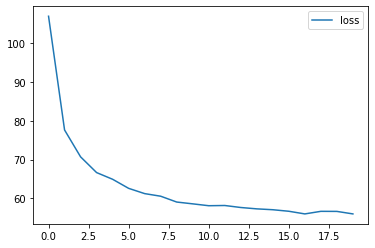

In [8]:
#ch_model.load_state_dict(torch.load('./models/RNN-2022-07-05.model', map_location=torch.device('cpu')))
ch_model = train(ch_model, input_vect, target_vect, lr=0.01, n_epochs=20, max_num_batches=100)
#torch.save(ch_model.state_dict(), './models/char_rnn.model')

In [9]:
#torch.save(ch_model.state_dict(), './models/char_rnn.model')

In [90]:
print(generate_sequence(ch_model, char2id, id2char, seed_seq="the", seq_len=50, temperature=0.7))

themm of the a thind to who have love. I like or f


In [ ]:
Conclusion: it generates some gibberish. This can probably be improved by getting a larger dataset,
    more training time and maybe using better e